Inspired by [paper](https://www.researchgate.net/publication/237135894_A_unifying_framework_for_complexity_measures_of_finite_systems)

In this notebook I will implement TSE and Excess Entropy calculation and test it on following datasets:



1.   Wikipedia
2.   Simple English Wikipedia


# Preparation

In [1]:
!python3 -m pip install sentencepiece > /dev/null && echo 'OK'

OK


In [2]:
!python3 -m pip install tensorflow_text > /dev/null && echo 'OK'

OK


In [3]:
!python3 -m pip install tensorflow_datasets > /dev/null && echo 'OK'

OK


In [4]:
!python3 -m pip install tf_sentencepiece > /dev/null && echo 'OK'

OK


### Imports

In [5]:
import sentencepiece as spm
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
import numpy as np
from typing import List, Tuple
import nltk
import matplotlib.pyplot as plt

# Datasets

## Wikipedia

[link](https://www.tensorflow.org/datasets/catalog/wiki40b#wiki40ben_default_config) to dataset

In [6]:
ds = tfds.load('wiki40b/en', split='train', shuffle_files=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset wiki40b downloaded and prepared to /root/tensorflow_datasets/wiki40b/en/1.3.0. Subsequent calls will reuse this data.


In [111]:
MAX_TEXTS_SIZE = 10000

texts = []
for x in ds:
    if len(texts) > MAX_TEXTS_SIZE:
        break
    s = x['text'].numpy().decode('utf-8')
    text = s.replace('_NEWLINE_', ' ').replace('_START_ARTICLE_', '').replace('_START_PARAGRAPH_', '').replace('_START_SECTION_',' ').split('\n')
    texts += list(filter(lambda x: len(x) > 20, text))

In [112]:
with open('train_text.txt', 'w') as fout:
    for text in texts:
        fout.write(text)
        fout.write('\n')

In [113]:
spm.SentencePieceTrainer.train('--input=train_text.txt --model_prefix=m --vocab_size=500')

In [114]:
sp = spm.SentencePieceProcessor()
sp.load('m.model')

True

In [115]:
print(list(sp.id_to_piece(i) for i in range(sp.vocab_size())))
print(sp.vocab_size())

['<unk>', '<s>', '</s>', 's', '▁', 'e', '▁the', ',', 't', '.', 'a', 'o', 'ed', '▁of', 'y', 'n', '▁in', 'c', '▁a', 'i', '▁and', 'd', 'u', 'ing', 'p', '▁to', 'al', 'er', 'g', 'ar', 'b', 'r', 'm', 'l', 'or', 'an', 'in', 're', '▁c', '1', 'le', 'f', 'en', 'k', 'on', '▁S', 'ic', 'ri', 'ur', '▁was', 'it', '▁f', 'v', 'h', 'es', 'th', '▁re', '▁The', '-', '▁B', 'w', 'st', '▁for', 'ch', '▁C', '▁P', '▁A', 'ly', '▁w', 'at', 'ter', 'ation', '▁b', 'ro', 'ent', '0', '▁is', 'un', '▁M', '▁p', "'", 'as', 'ad', 'il', '▁(', 'us', 'ra', '▁on', '▁with', 'ul', '▁19', '▁D', '▁T', '▁as', '▁st', '▁G', '▁F', '▁de', 'el', '3', '5', '▁by', '▁In', '▁H', '9', '2', '4', 'ce', 'ion', '6', 'ol', '▁m', 'ir', '▁20', 'is', '▁be', '8', 'am', '▁W', '▁that', 'ne', '▁he', '▁L', '7', '▁at', 'ec', '▁his', '▁E', '▁J', 'ver', ')', '▁from', '▁con', 'ment', 'et', '▁mo', 'tion', 'x', 'ate', '"', 'la', 'li', 'om', 've', '▁an', '▁pro', 'ut', 'te', 'im', '▁N', 'se', '▁R', 'ill', 'ist', 'ow', 'ive', '▁e', '▁g', '▁"', 'ain', '▁ma', 'id', 

In [116]:
print(sp.encode_as_ids('Hello, my friend'))
print(sp.encode_as_pieces('Hello, my friend'))

[103, 190, 11, 7, 111, 14, 51, 47, 192]
['▁H', 'ell', 'o', ',', '▁m', 'y', '▁f', 'ri', 'end']


In [117]:
def collect_statistics(
    texts: List[str], 
    sp: spm.SentencePieceProcessor
) -> Tuple[np.ndarray]:
    """
    texts: the list of str texts
    sp: pretrained sentencepieces tokenizer

    Returns
    - a nltk.FreqDist with counts for (i, (x_{i-1}, x_i))
    - a nltk.FreqDist with counts for (i, x_i)
    - a nltk.FreqDist with counts for (i, x_i), where i is the last position of the sequence
    - a nltk.FreqDist with counts for i - the number of texts with i-th position
    """

    vocab_size = sp.vocab_size()
    bins = np.arange(vocab_size + 1)

    F_pair = nltk.FreqDist()
    F_single = nltk.FreqDist()
    F_last = nltk.FreqDist()
    F_pos = nltk.FreqDist()

    for text in tqdm(texts):
        tokenized_sequence = sp.encode_as_ids(text)
        bgs = nltk.bigrams(tokenized_sequence)
        F_pair += nltk.FreqDist(zip(range(1, len(tokenized_sequence)), bgs))
        F_single += nltk.FreqDist(zip(range(len(tokenized_sequence)), tokenized_sequence))
        F_last += nltk.FreqDist([(len(tokenized_sequence) - 1, tokenized_sequence[-1])])
        F_pos += nltk.FreqDist(range(len(tokenized_sequence)))
    
    return F_pair, F_single, F_last, F_pos

In [118]:
F_pair, F_single, F_last, F_pos = collect_statistics(texts, sp)

## Simple English wikipedia

some [link](https://github.com/LGDoor/Dump-of-Simple-English-Wiki)

In [125]:
!git clone https://github.com/LGDoor/Dump-of-Simple-English-Wiki.git

Cloning into 'Dump-of-Simple-English-Wiki'...
remote: Enumerating objects: 6, done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 6
Unpacking objects: 100% (6/6), done.


In [129]:
!tar -xf Dump-of-Simple-English-Wiki/corpus.tgz

In [136]:
!ls -lh

total 39M
-rw-r--r-- 1  501 staff  32M Apr  9  2013 corpus.txt
drwxr-xr-x 3 root root  4.0K Nov 20 19:31 Dump-of-Simple-English-Wiki
-rw-r--r-- 1 root root  239K Nov 20 19:00 m.model
-rw-r--r-- 1 root root  6.7K Nov 20 19:00 m.vocab
drwxr-xr-x 1 root root  4.0K Nov 13 17:33 sample_data
-rw-r--r-- 1 root root  7.2M Nov 20 19:00 train_text.txt


In [203]:
SIMPLE_MAX_TEXTS_SIZE = 10000

simple_texts = []
with open('corpus.txt', 'r') as fin:
    for s in fin:
        if len(simple_texts) > SIMPLE_MAX_TEXTS_SIZE:
            break
        text = s.split('\n')
        simple_texts += list(filter(lambda x: len(x) > 20, text))

In [204]:
with open('simple_train_text.txt', 'w') as fout:
    for text in simple_texts:
        fout.write(text)
        fout.write('\n')

In [205]:
spm.SentencePieceTrainer.train('--input=simple_train_text.txt --model_prefix=s --vocab_size=500')

In [206]:
simple_sp = spm.SentencePieceProcessor()
simple_sp.load('s.model')

True

In [207]:
print(list(sp.id_to_piece(i) for i in range(sp.vocab_size())))
print(sp.vocab_size())

['<unk>', '<s>', '</s>', 's', '▁', 'e', '▁the', ',', 't', '.', 'a', 'o', 'ed', '▁of', 'y', 'n', '▁in', 'c', '▁a', 'i', '▁and', 'd', 'u', 'ing', 'p', '▁to', 'al', 'er', 'g', 'ar', 'b', 'r', 'm', 'l', 'or', 'an', 'in', 're', '▁c', '1', 'le', 'f', 'en', 'k', 'on', '▁S', 'ic', 'ri', 'ur', '▁was', 'it', '▁f', 'v', 'h', 'es', 'th', '▁re', '▁The', '-', '▁B', 'w', 'st', '▁for', 'ch', '▁C', '▁P', '▁A', 'ly', '▁w', 'at', 'ter', 'ation', '▁b', 'ro', 'ent', '0', '▁is', 'un', '▁M', '▁p', "'", 'as', 'ad', 'il', '▁(', 'us', 'ra', '▁on', '▁with', 'ul', '▁19', '▁D', '▁T', '▁as', '▁st', '▁G', '▁F', '▁de', 'el', '3', '5', '▁by', '▁In', '▁H', '9', '2', '4', 'ce', 'ion', '6', 'ol', '▁m', 'ir', '▁20', 'is', '▁be', '8', 'am', '▁W', '▁that', 'ne', '▁he', '▁L', '7', '▁at', 'ec', '▁his', '▁E', '▁J', 'ver', ')', '▁from', '▁con', 'ment', 'et', '▁mo', 'tion', 'x', 'ate', '"', 'la', 'li', 'om', 've', '▁an', '▁pro', 'ut', 'te', 'im', '▁N', 'se', '▁R', 'ill', 'ist', 'ow', 'ive', '▁e', '▁g', '▁"', 'ain', '▁ma', 'id', 

In [208]:
print(sp.encode_as_ids('Hello, my friend'))
print(sp.encode_as_pieces('Hello, my friend'))

[103, 190, 11, 7, 111, 14, 51, 47, 192]
['▁H', 'ell', 'o', ',', '▁m', 'y', '▁f', 'ri', 'end']


In [209]:
simple_F_pair, simple_F_single, simple_F_last, simple_F_pos = collect_statistics(simple_texts, simple_sp)

# Calculating metrics

## Excess Entropy

Friendly reminder:

Suppose that we have a sequence of tokens $x_0, x_1, \ldots, x_{n-1}$.
We want to calculate $E(x_0, x_1, \ldots, x_{n-1})$

In original papers this metrics can be calculated only of some multidimensional random value, but not of sequence of numbers. 

So, $E(X_0, X_1, \ldots, X_{n-1}) = (n-1)\left(\frac{1}{n-1}\sum\limits_{i=0}^{n-1}H(X_0, X_1, \ldots, X_{i-1}, X_{i+1}, \ldots, X_{n-1}) - H(X_0, \ldots, X_{n-1})\right)$

The problem is how to calculate $H(\ldots)$ if we have only a sequence of numbers.

First of all, let's simplify the problem: we want to create such r.v. $\xi_i$ from our numbers in such a way that $H(\xi_0, \ldots, \xi_{n-1}) = H(\xi_0) + H(\xi_1|\xi_0) + \ldots + H(\xi_{n-1}|\xi_{n-2})$. How can we find such r.v.?

Notice that $xi_i$ should depends on the position ($i$) in the sequence and on number at this position ($x_i$).

Let's construct r.v. by $x_i$. So, $x_i$ will generate r.v. $\xi^i_{x_i}$. What the distribution of such r.v. is?

* $p(\xi^0_{x_0}) = \frac{\#\text{sequences with $x_0$ at the very beginning}}{\#\text{of first positions}}$

* $p(\xi^i_{x_i}, \xi^{i-1}_{x_{i-1}}) = \frac{\#\text{sequences with $x_{i-1}$ at position $i-1$ and $x_i$ at position $x_i$}}{\#\text{sequences with $i$-th position}}$

Then we can define Excess Entropy of sequence of numbers

$E(x_0, \ldots, x_{n-1}) = E(\xi^0_{x_0}, \xi^1_{x_1}, \ldots, \xi^{n-1}_{x_{n-1}})$

How to calculate it efficiently?

Let's denote $\mu_i = \xi^i_{x_i}$

* $\hat{H} = H(\mu_0, \ldots, \mu_{n-1}) = H(\mu_0) + H(\mu_1|\mu_0) + \ldots + H(\mu_{n-1} | \mu_{n-2})$
    * $H(\mu_i) = -p(\mu_i)\log p(\mu_i) - (1-p(\mu_i))\log (1 - p(\mu_i))$
    * $H(\mu_i,\mu_{i-1}) = -p(\mu_i,\mu_{i-1})\log p(\mu_i,\mu_{i-1}) - (1 - p(\mu_i,\mu_{i-1}))\log(1 - p(\mu_i, \mu_{i-1}))$
    * $H(\mu_i|\mu_{i-1}) = H(\mu_i, \mu_{i-1}) - H(\mu_{i-1})$
* $H(\mu_0, \ldots, \mu_{i-1}, \mu_{i+1}, \ldots, \mu_{n-1}) = \hat{H} - H(\mu_i|\mu_{i-1}) - H(\mu_{i+1}|\mu_i) + H(\mu_{i+1}|\mu_{i-1}) = $
$=\hat{H} - H(\mu_i|\mu_{i-1}) - H(\mu_{i+1}|\mu_i) + H(\mu_{i+1})$

So, we can easily calculate Excess Entropy in $O(n)$ time

**Note**: actually, we do not calculate pure entropy, but we calculate some metric, which is very similar to it. The problem is that we are working with binary random variables and it is hard to make a relationship between binary r.v. for pair $(\mu_i, \mu_{i-1})$ and binary r.v. for $\mu_i$.

**Note**: if we will define r.v. which depends only on values then we can not easily calculate Excess entropy, because there is dependency between all r.v.

In [201]:
def calculate_excess_entropy(
    texts: List[str], 
    sp: spm.SentencePieceProcessor,
    F_pair: nltk.FreqDist,
    F_single: nltk.FreqDist,
    F_last: nltk.FreqDist,
    F_pos: nltk.FreqDist
) -> np.ndarray:
    """
    texts: the list of str texts
    sp: pretrained sentencepieces tokenizer
    F_pair: nltk.FreqDist with counts for (i, (x_{i-1}, x_i))
    F_single: nltk.FreqDist with counts for (i, x_i)
    F_last: nltk.FreqDist with counts for (i, x_i), where i is the last position of the sequence
    F_pos: nltk.FreqDist with counts for i - the number of texts with i-th position
    
    Returns
    - a (# of texts,) numpy array with excess entropy calculated for each text
    """

    EPS = 1e-9
    def calculate_entropy(p):
        if p > 1 - EPS or p < EPS:
            return 0
        return -p * np.log(p + EPS) - (1 - p) * np.log(1 - p)

    def H_single(i, xi, verbose: bool = False):
        p = F_single[(i, xi)] / F_pos[i]
        if verbose:
            print(p)
        return calculate_entropy(p)

    def H_pair(i, prev, cur, verbose: bool = False):
        p = F_pair[(i, (prev, cur))] / F_pos[i]
        if verbose:
            print(p)
        return calculate_entropy(p) - H_single(i - 1, prev)

    ee = np.zeros(len(texts), dtype=float)

    for id, text in tqdm(enumerate(texts)):
        x = sp.encode_as_ids(text)
        n = len(x)
        H_hat = 0
        delta = 0
        for i in range(n):
            if i == 0:
                H_hat += H_single(0, x[i])
            else:
                H_hat += H_pair(i, x[i - 1], x[i])
            if i > 0:
                delta += -H_pair(i, x[i - 1], x[i])
            if i + 1 < n:
                delta += -H_pair(i + 1, x[i], x[i + 1]) + H_single(i + 1, x[i + 1])
        ee[id] = delta + H_hat

    return ee

In [202]:
ee = calculate_excess_entropy(
    texts,
    sp,
    F_pair,
    F_single,
    F_last,
    F_pos
)

In [192]:
print(ee.min(), ee.max(), ee.mean(), ee.std())

-743.9735127688363 753.7530890787589 -91.0420270319473 124.93226330525333


In [193]:
lens = np.array([len(sp.encode_as_ids(text)) for text in texts])

In [210]:
simple_ee = calculate_excess_entropy(
    simple_texts,
    simple_sp,
    simple_F_pair,
    simple_F_single,
    simple_F_last,
    simple_F_pos
)

In [211]:
print(simple_ee.min(), simple_ee.max(), simple_ee.mean(), simple_ee.std())

0.1690015166881823 165.52096049489685 10.170651639646135 8.789070746799466


In [212]:
simple_lens = np.array([len(sp.encode_as_ids(text)) for text in simple_texts])

''

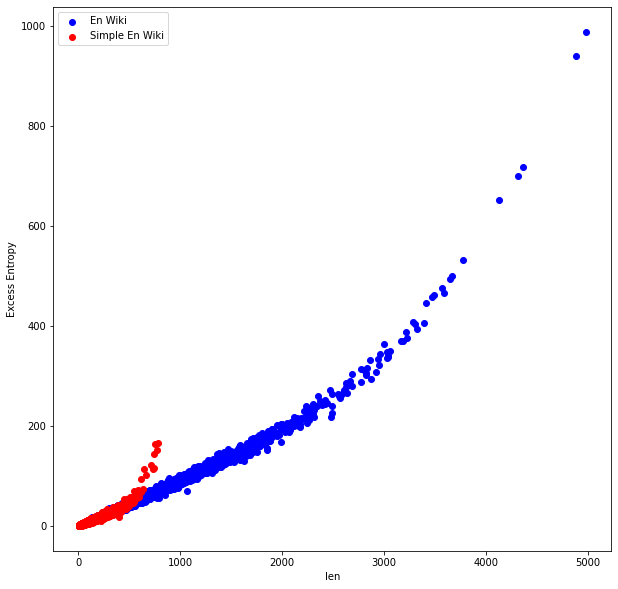

In [213]:
plt.figure(figsize=(10, 10))
plt.xlabel('len')
plt.ylabel('Excess Entropy')
plt.scatter(lens[lens < 5000], ee[lens < 5000], color='blue', label='En Wiki')
plt.scatter(simple_lens, simple_ee, color='red', label='Simple En Wiki')
plt.legend()
;

## TSE Complexity

We have sequence of numbers (tokens): $x_0, \ldots, x_{n-1}$

Let's denote 
* $V_i = \{0, 1, \ldots, i\}$
* $V = V_{n-1}$
* $\mu_A = \mu_{i_0}, \mu_{i_1}, \ldots, \mu_{i_{k-1}}$, where $A = \{i_0, i_1, \ldots, i_{k-1}\}$ and $i_{j} < i_{j+1}$


TSE Complexity is $C(\mu_V) = \sum\limits_{k=1}^{n-1}\frac{k}{n}C^{(k)}(\mu_V)$, where

$C^{(k)}(\mu_V) = \left[\frac{n}{k}\cdot\frac{1}{\binom{n}{k}}\sum\limits_{A\subset V, |A| = k}H(\mu_A)\right] - H(\mu_V)$

We already know, how to calculate $H(\mu_V)$.

How can we calculate left term of given formula. Let's use dynamic programming, which allows us to do it in $O(n^2)$ time complexity.

Let's define 

* $d(i, k) = \frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_i, |A| = k} H(\mu_A)$, 

    where $0 \le i < n, 0 \le k < n$

* $d(i, 0) = 0$

    $\forall 0 \le i < n$

then 

* $C^{(k)}(\mu_V) = \frac{n}{k}d(n - 1, k) - H(\mu_V)$
    
    $C(\mu_V) = \sum\limits_{k=1}^{n-1}\left(d(n - 1, k) - \frac{k}{n}H(\mu_v)\right) = \left[\sum\limits_{k=1}^{n-1}d(n-1,k)\right] - \frac{n-1}{2}H(\mu_V)$

Transition:

$d(i, k) = \frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_i, |A| = k} H(\mu_A) =$

$=\left[\frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-1}, |A| = k} H(\mu_A)\right]
+ \left[\frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-1}, |A| = k-1,} H(\mu_{A\cup\{i\}})\right]
=$

$=\left[\frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-1}, |A| = k} H(\mu_A)\right]
+ \left[\frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-2}, |A|=k-1}H(\mu_{A\cup\{i\}})\right]
+ \left[\frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-2}, |A|=k-2}H(\mu_{A\cup\{i-1,i\}})\right] = A + B + C$

Let's introduce two definitions
1. $d^0(i, k) = \frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-1},|A|=k}H(\mu_A)$. 
    
    $d^0(i, 0) = 0$
2. $d^1(i, k) = \frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-1},|A|=k-1}H(\mu_{A\cup{\{i\}}})$. 
    
    $d^1(i, 0) = 0$

then we have 
* $d(i, k) = d^0(i, k) + d^1(i, k)$
* $d^0(i, k) = d(i - 1, k)$

Then if $i > 0$

* $A = \frac{i-k}{i}d(i-1,k)$

* $B = \frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-2},|A|=k-1}\left[H(\mu_A) + H(\mu_i)\right] = \left[\frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-2},|A|=k-1}H(\mu_A)\right] + \frac{\binom{i-1}{k-1}}{\binom{i}{k}}H(\mu_i) =$

$= \frac{i-k}{i}d^0(i-1,k-1) + \frac{k}{i}H(\mu_i)$

* $C = \frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-2}, |A|=k-2}\left[H(\mu_{A\cup\{i-1\}}) + H(\mu_i|\mu_{i-1})\right] = \frac{i-k}{i}d^1(i-1,k-1) + \frac{\binom{i-1}{k-2}}{\binom{i}{k}}H(\mu_i|\mu_{i-1}) = $

$=\frac{i-k}{i}d^1(i-1,k-1) + \frac{k(k-1)}{i(i-k+1)}H(\mu_i|\mu_{i-1})$

**Note**: $\binom{i}{k}=\frac{i!}{k!(i-k)!}=\frac{(i-1)!i}{k!(i-1-k)!(i-k)}=\binom{i-1}{k}\frac{i}{i-k}$

if $i = 0$ then 
* $d(0, 1) = H(\mu_0)$
* $d(0, k) = 0$

    $\forall k > 1$
